# Joint Modelling of Multiple Bands

In this example we will showcase the ability of pysersic to jointly model multiple bands while 'linking' morphological parameters across wavelength using a smooth function. For this we will use an example galaxy from the DeCALS survey observed in g,r and z bands.

In [1]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
from astropy.visualization import make_lupton_rgb
import sep
import arviz as az
import jax

from pysersic.priors import autoprior
from pysersic import FitSingle
from pysersic.loss import student_t_loss


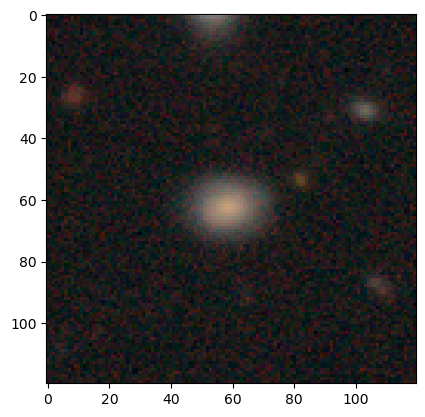

In [2]:
## Load data from legacy survey sky server from this url:
## https://www.legacysurvey.org/viewer/data-for-radec/?ra=59.1067&dec=-30.4848&layer=ls-dr9&ralo=59.0670&rahi=59.1320&declo=-30.5002&dechi=-30.4702

## This galaxy was found simply by panning around in the skyserver.

psf_fits = fits.open('./examp_gals/copsf_59.1067_-30.4848.fits')
img_fits = fits.open('./examp_gals/cutout_59.1067_-30.4848.fits')
mid = int(256/2)
dx = 60

band_list = ['g','r','z']
wv_list = [0.472, 0.642,0.926]

psf_dict = {}
img_dict = {}
rms_dict = {}
for j,band in enumerate(band_list):
    psf_dict[band] = np.array(psf_fits[j].data).byteswap().newbyteorder()
    img_dict[band] = np.array(img_fits[1+2*j].data)[mid-dx:mid+dx,mid-dx:mid+dx ].byteswap().newbyteorder()
    rms_dict[band] = 1/np.sqrt( np.array(img_fits[2+2*j].data) )[mid-dx:mid+dx,mid-dx:mid+dx].byteswap().newbyteorder()

rgb = make_lupton_rgb(img_dict['z'],img_dict['r']*1.2, img_dict['g']*1.75, stretch= 0.1, Q = 5, minimum=-1e-2)
plt.imshow(rgb)

We can already see the hints of a color gradient in this galaxy, where the blue light seems more extended and the center seems redder. This is very common in many different types of galaxies and we want change in morphology as a function of wavelength as it gives us information about gradients in dust or stellar populations.

Below we will set up and run individual fits and then showcase the joint fitting capabilities in `pysersic.multiband`

In [3]:
## Derive a mask based on 'r' band
cat,seg = sep.extract(img_dict['r'], thresh=3., err = rms_dict['r'], segmentation_map= True,)
obj_id = seg[60,60]
mask = seg.copy()
mask[np.where(seg ==obj_id)] = 0
mask[mask>=1] = 1

# Find priors for each band
prior_dict = {}
for band in band_list:
    prior_dict[band] = autoprior(img_dict[band], 'sersic', mask, sky_type='flat')
    print 
    print (band,prior_dict[band])

g Prior for a sersic source:
--------------------------
flux ---  Normal w/ mu = 16.49, sigma = 8.12
xc ---  Normal w/ mu = 58.41, sigma = 1.00
yc ---  Normal w/ mu = 62.34, sigma = 1.00
r_eff ---  Truncated Normal w/ mu = 7.53, sigma = 5.49, between: 0.50 -> inf
ellip ---  Uniform between: 0.00 -> 0.90
theta ---  Uniform between: 0.00 -> 6.28
n ---  Uniform between: 0.65 -> 8.00
sky type - Base
sky_back --- Normal with mu = 1.403e-04 and sd = 8.020e-05

r Prior for a sersic source:
--------------------------
flux ---  Normal w/ mu = 26.70, sigma = 10.33
xc ---  Normal w/ mu = 58.45, sigma = 1.00
yc ---  Normal w/ mu = 62.40, sigma = 1.00
r_eff ---  Truncated Normal w/ mu = 7.13, sigma = 5.34, between: 0.50 -> inf
ellip ---  Uniform between: 0.00 -> 0.90
theta ---  Uniform between: 0.00 -> 6.28
n ---  Uniform between: 0.65 -> 8.00
sky type - Base
sky_back --- Normal with mu = 2.141e-04 and sd = 1.000e-04

z Prior for a sersic source:
--------------------------
flux ---  Normal w/ mu = 

In [4]:
#Loop through and run fit in each of the 3 bands
fitter_dict = {}
ind_res_dict = {}
rkey = jax.random.PRNGKey(12)
for band in band_list:
    rkey,_ = jax.random.split(rkey, 2) # use differeny random number key for each run
    fitter_cur = FitSingle(
        data=img_dict[band], 
        rms = rms_dict[band],
        psf = psf_dict[band],
        prior = prior_dict[band], 
        mask = mask.copy(),
        loss_func = student_t_loss
    )
    print (f'Running fit - {band}')
    ind_res_cur = fitter_cur.estimate_posterior(rkey = rkey)
    ind_res_dict[band] = ind_res_cur.retrieve_med_std()
    fitter_dict[band] = fitter_cur

Running fit - g


  1%|▏         | 251/20000 [00:00<00:26, 735.48it/s, Round = 2,step_size = 5.0e-04 loss: -6.564e+04]


Running fit - r


  1%|▏         | 255/20000 [00:00<00:26, 733.64it/s, Round = 2,step_size = 5.0e-04 loss: -6.241e+04]


Running fit - z


  1%|▏         | 251/20000 [00:00<00:27, 728.82it/s, Round = 2,step_size = 5.0e-04 loss: -4.542e+04]


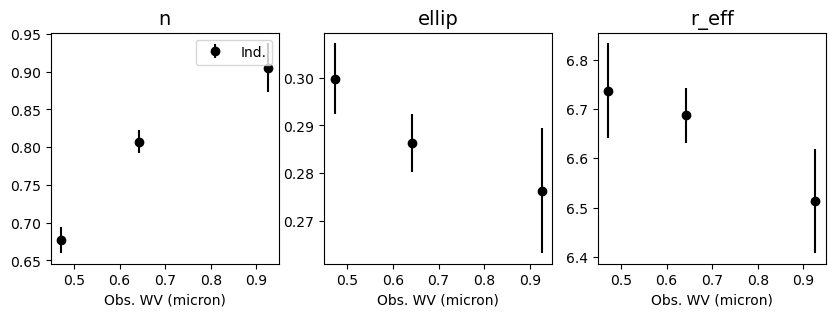

In [5]:
fig, axes = plt.subplots(1,3, figsize = (10,3))

for j,param in enumerate(['n','ellip','r_eff']):
    ax = axes[j]

    med_ind = [ind_res_dict[b][param][0] for b in band_list]
    err_ind = [ind_res_dict[b][param][1] for b in band_list]
    ax.errorbar(wv_list, med_ind, yerr=err_ind, fmt = 'o', color = 'k', label = 'Ind.')
    ax.set_xlabel('Obs. WV (micron)')
    ax.set_title(param, fontsize = 14)
axes[0].legend()

We can see that the index gets larger and the effictive radius declines as a function of wavelength! This is super common in spiral galaxies like this one and usually due to a centrally concentrated older, and therefore redder, stellar population. (see https://arxiv.org/abs/2102.06703 for very nice recent paper!)

While it is entirely reasonable to fit the image separately in each band as we have done above, we can use the fact the we expect the morphological properties to change smoothly as a function of wavelength. This let's us parameterize the parameters as a function of wavelength and model the bands simultaneously. This will lead to more consistent predictions across bands, as we are enforcing smoothness, and lead to better constraints on parameters, especially if some of the bands have low S/N.

To start we will import `FitMultiBandPoly` from the `pysersic.multiband` module. This uses a polynomial to "link" the parameters across wavelength. We then instantiate the multi-band fitter using a list of `FitSingle` objects for each band (This also works with `FitMulti` objects as well!). We then base the names of the bands and their central wavelength.

Next we must decide which parameters we want to be 'linked'. For these parameters `pysersic` will parameterize them with a polynomial as a function of wavelength. For this example we choose the index, `n`, the ellipticity and effective radius to be linked. This is a common choice for parameters to be linked. We then specify the central position (xc and yc) and position angle to be constant. This mean `pysersic` will fit the same parameter for all of the bands. In detail it uses the prior from the first fitter in the list. This means that the flux will be left to vary independently still. This is a common choice as we know galaxy SEDs have complex shapes that are difficult to capture with simple functions like polynomials.

Finally we specificy `wv_to_save` which is an array of wavelengths to save the smooth functions for the linked parameters, and the order of the polynomial, for us 2 or a quadratic function.

In [6]:
from pysersic.multiband import FitMultiBandPoly
wv_to_save = np.linspace(min(wv_list),max(wv_list), num = 50)
MultiFitter = FitMultiBandPoly(fitter_list=[fitter_dict[b] for b in band_list],
                               wavelengths=wv_list,
                               band_names= band_list,
                               linked_params=['n','ellip','r_eff'],
                               const_params=['xc','yc','theta'],
                               wv_to_save= wv_to_save,
                               poly_order = 2)
rkey,_ = jax.random.split(rkey,2)
multires = MultiFitter.estimate_posterior(rkey = rkey)

  1%|▏         | 252/20000 [00:01<01:20, 246.79it/s, Round = 2,step_size = 5.0e-04 loss: -1.735e+05]


Note that the `FitMultiBand[x]` classes utilize the same inference framework as `FitSingle` and `FitMulti`

In [7]:
link_params = [f'{param}_{b}' for b in band_list for param in ['r_eff','n','ellip']] # Look at posteriors of "linked" parameters
multi_res_dict = multires.retrieve_med_std()
az.summary(multires.idata, var_names=link_params)

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
r_eff_g,6.883,0.075,6.742,7.017,0.003,0.002,738.0,799.0,NaN
n_g,0.708,0.013,0.685,0.733,0.000,0.000,771.0,912.0,NaN
ellip_g,0.304,0.008,0.290,0.317,0.000,0.000,969.0,845.0,NaN
r_eff_r,6.659,0.058,6.545,6.761,0.002,0.001,1146.0,952.0,NaN
n_r,0.799,0.015,0.768,0.825,0.000,0.000,1140.0,881.0,NaN
ellip_r,0.286,0.006,0.274,0.296,0.000,0.000,1069.0,792.0,NaN
r_eff_z,6.481,0.110,6.288,6.694,0.003,0.002,1091.0,983.0,NaN
n_z,0.897,0.034,0.838,0.967,0.001,0.001,1122.0,937.0,NaN
ellip_z,0.272,0.013,0.244,0.293,0.000,0.000,949.0,878.0,NaN


Now let's compare the individual and joint fits:

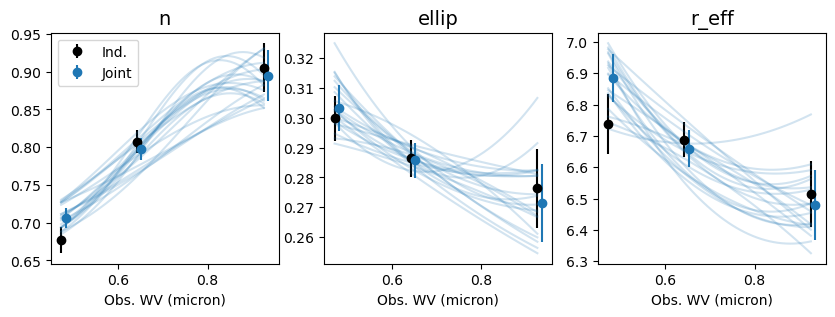

In [8]:
fig, axes = plt.subplots(1,3, figsize = (10,3))

for j,param in enumerate(['n','ellip','r_eff']):
    ax = axes[j]

    med_ind = [ind_res_dict[b][param][0] for b in band_list]
    err_ind = [ind_res_dict[b][param][1] for b in band_list]

    med_multi = [multi_res_dict[f'{param}_{b}'][0] for b in band_list]
    err_multi = [multi_res_dict[f'{param}_{b}'][1] for b in band_list]
    
    ax.errorbar(wv_list, med_ind, yerr=err_ind, fmt = 'o', color = 'k', label = 'Ind.')
    ax.errorbar(np.array(wv_list)+0.01, med_multi, yerr=err_multi, fmt = 'o', color = 'C0', label = 'Joint')
    param_smooth = multires.idata.posterior[f'{param}_at_wv'].data.squeeze()
    ax.plot(wv_to_save, param_smooth[:20].T, 'C0-', alpha = 0.2)
    ax.set_title(param, fontsize = 14)
    ax.set_xlabel('Obs. WV (micron)')
axes[0].legend()

We can see the joint multi-band fits agree well with the independent fits. For this example we only see a modest improvement in the constraints, about 5%-10%. However this is not a great showcase as it is a well detected galaxy in only 3 bands although it can still be useful to derive a smooth function for the parameters a function of wavelength. The multi-band fitting really shines with five or more bands especially with low S/N, where the constraints on morphological parameters can improve by as much as 50%-75%.

We also have implemented `FitMultiBandBSpline` which uses a basis spline instead of a polynomial to link parameters across wavelength. This can be more flexible that a polynomial so should provide improvements when a large wavelength baseline is used.

Currently the `FitMultiBand[x]` classes assume the pixel scale and zero-points are the same across all of the input bands. We are working on implementing a more flexible interface so say tuned! If there are any other adjustments or features we can add to help your use case, the best way to contact us is the right and issue on github!